In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import find_peaks
import time
import sounddevice as sd
import noisereduce as nr

from spectrogram import Spectogram

In [2]:
spect = Spectogram(linewidth=2, time_step=0.05)

In [3]:
data, sample_rate = sf.read("angle-grinder-313298.mp3")
data = np.sum(data, axis=1)
data.shape

(1828224,)

In [4]:
spect.set(data)

<Axes: >

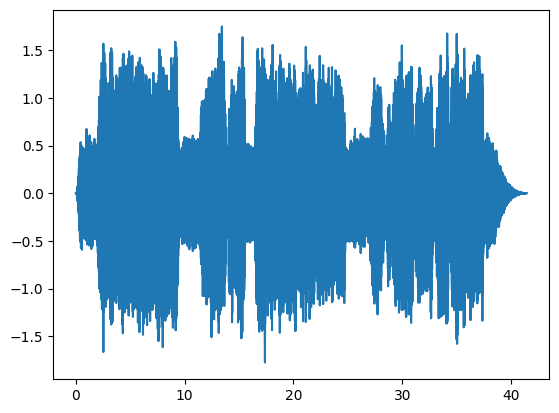

In [5]:
spect.plot_data()

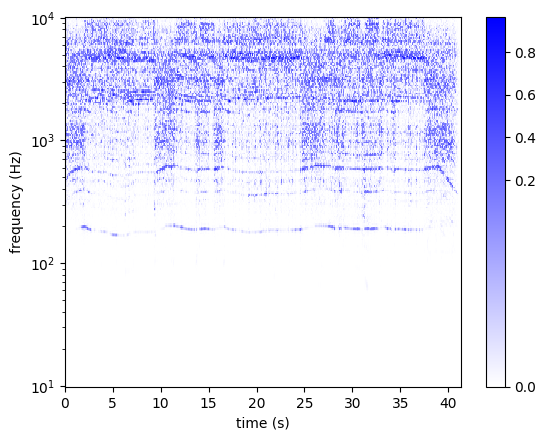

In [7]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

maximum = 4818.73 Hz


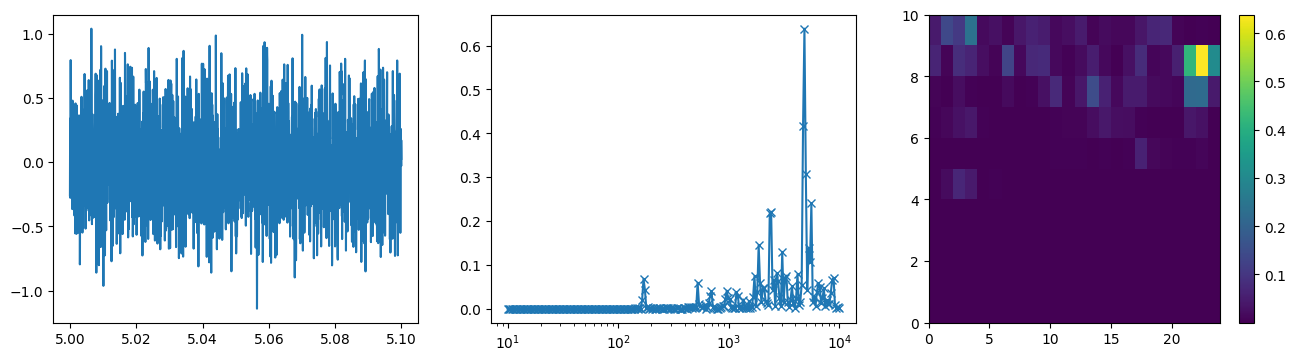

In [9]:
t = 5 #sec
kmax, numax, vmax = spect.find_maxima_in_spectrum(t)[0]
print(f'maximum = {numax:.2f} Hz')
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
sample = spect.data_slice(t, t+spect.tint)
times = np.linspace(t, t+spect.tint,len(sample))
ax[0].plot(times, sample)
spect.plot_spectrum(t, ax=ax[1], marker='x')
mesh = spect.plot_octaves_2D(t, ax=ax[2], cmap='viridis')
fig.colorbar(mesh, ax=ax[2])
plt.show()

<Axes: >

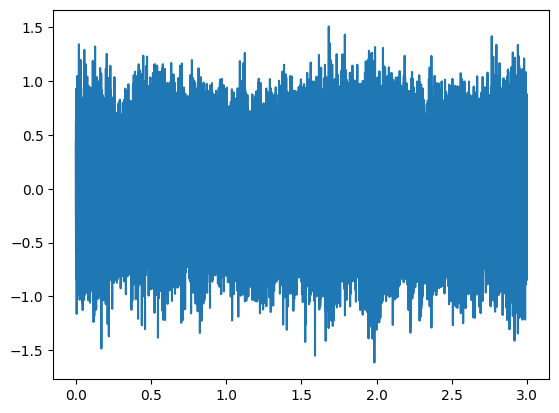

In [27]:
sample =spect.data_slice(6,9,data)
spect.set(sample)
spect.plot_data()

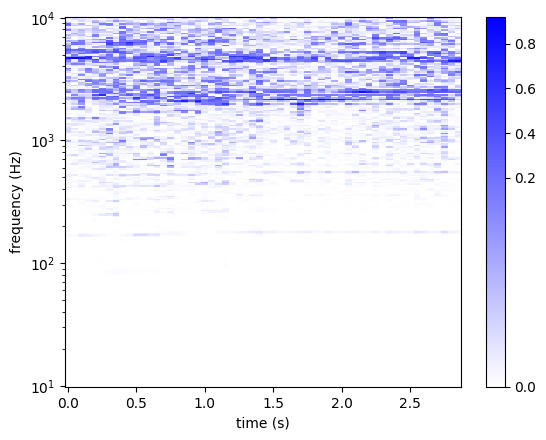

In [28]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

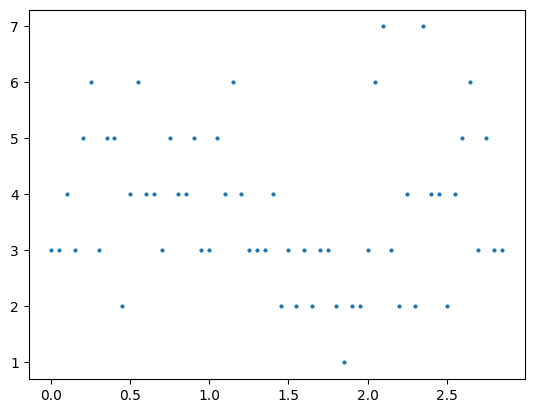

In [31]:
threshold = 0.2
times, peaks = spect.find_maxima_in_spectrogram(threshold=threshold)
plt.plot(times, [len(v) for v in peaks], 'o', ms=2)

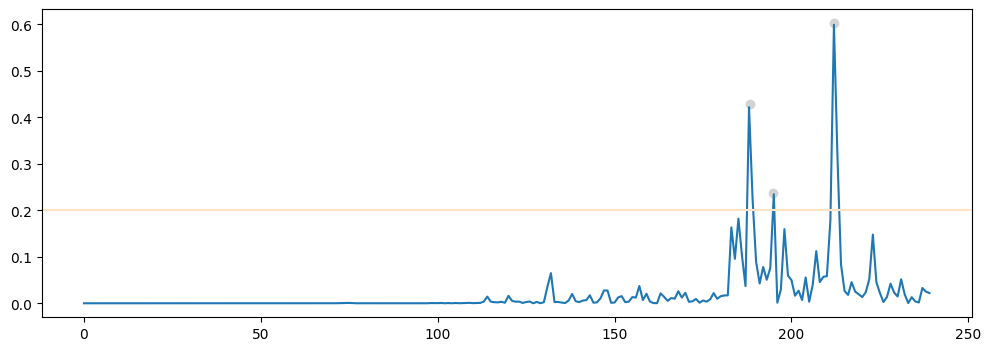

In [32]:
t = 1
n = spect.time_to_index(1/spect.timestep, t)
fig,ax = plt.subplots(ncols=1, figsize=(12,4) )
ax.plot(spect.spectrum_data[n])
ax.axhline(threshold,color='bisque')
for pos, freq, height in peaks[n]:
    ax.scatter(pos, height, color='lightgrey')

In [33]:
spect.spectrum_data.shape

(58, 240)

IndexError: index 100 is out of bounds for axis 0 with size 58

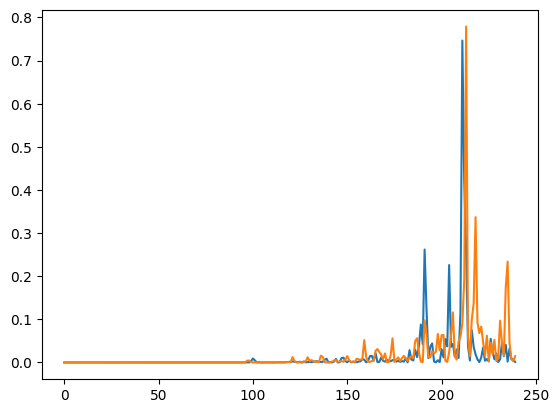

In [34]:
plt.plot(spect.spectrum_data[-1,:])
plt.plot(spect.spectrum_data[0])
plt.plot(spect.spectrum_data[int(5/spect.timestep)])
plt.plot(spect.spectrum_data[int(20/spect.timestep)])

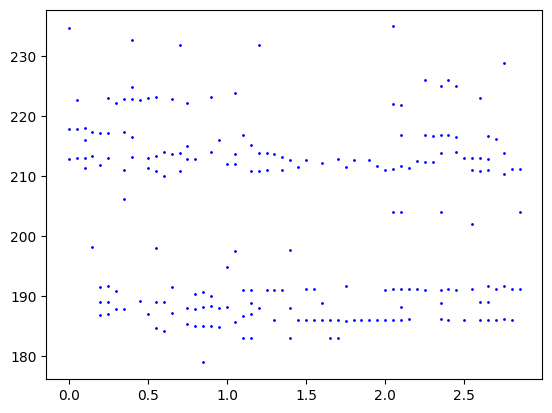

In [37]:
for i,p in enumerate(peaks):
    if len(p)==0:
        continue
    t = times[i]
    plt.plot(t*np.ones(shape=p.shape[0]), p[:,0], 'o', color='blue', ms=1)

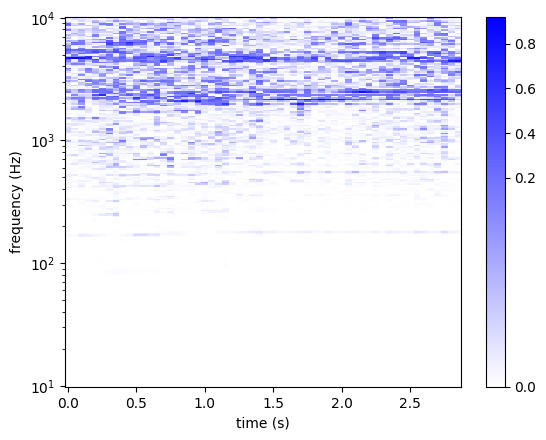

In [38]:
fig, ax = plt.subplots()
mesh = spect.show_spectrogram(ax=ax)
fig.colorbar(mesh, ax=ax)
plt.show()

In [40]:
tolerance=3
trackers = [ [[0, int(u), float(v)]] for u,_,v in peaks[0]]
for timeindex, p in enumerate(peaks[1:]):
    for u,_,v in p:
        newitem = [timeindex+1, int(u), float(v)]
        foundtracker = False
        for i,tr in enumerate(trackers):
            if np.abs(tr[-1][1]-u)<tolerance:
                foundtracker=True
                trackers[i].append(newitem)
        if not foundtracker:
            trackers.append([newitem])
len(trackers)


33

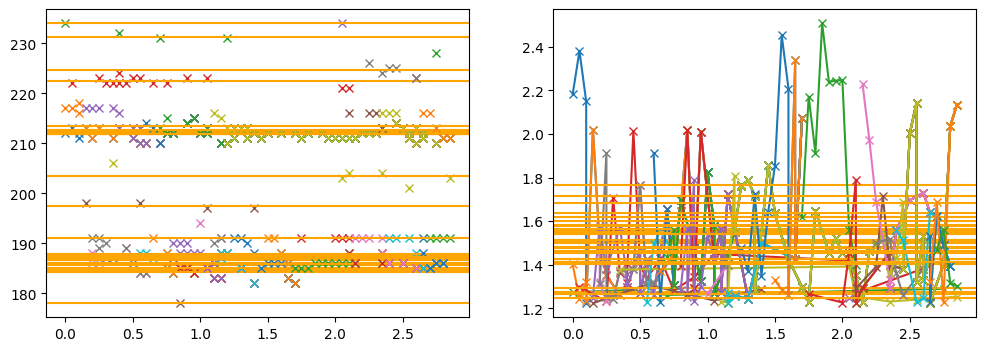

In [41]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for tracker in trackers:
    times, freqs, heights = np.array(tracker).T
    times = spect.timestep*times
    freqmean = np.mean(freqs)
    heightmean = np.mean(np.exp(heights))

    ax[0].plot(times, freqs, 'x')#, color='tab:blue')
    ax[0].axhline(freqmean, color='orange')
    ax[1].plot(times, np.exp(heights),'x-')
    ax[1].axhline(heightmean, color='orange')

In [51]:
trackerlens = [len(tr) for tr in trackers]
trackerfreqs = [np.mean(np.array(tr)[:,1]) for tr in trackers]
sorted_indices = np.argsort(trackerfreqs)
stable_tracks = [trackers[sorted_indices[0]].copy()]
stable_tracksfreqs = [trackerfreqs[sorted_indices[0]].copy()]
stable_tracksindex = [[sorted_indices[0]]]
tolerance = 2.5
for i in sorted_indices[1:]:
    if np.abs(trackerfreqs[i]-stable_tracksfreqs[-1])<tolerance:
        stable_tracks[-1].extend(trackers[i].copy())
        stable_tracks[-1] = sorted(stable_tracks[-1], key= lambda x: x[0])
        stable_tracksfreqs[-1] = np.mean(np.array(stable_tracks[-1])[:,1])
        stable_tracksindex[-1].append(i)
    else:
        stable_tracks.append(trackers[i].copy())
        stable_tracksfreqs.append(np.mean(np.array(stable_tracks[-1])[:,1]))
        stable_tracksindex.append([i])




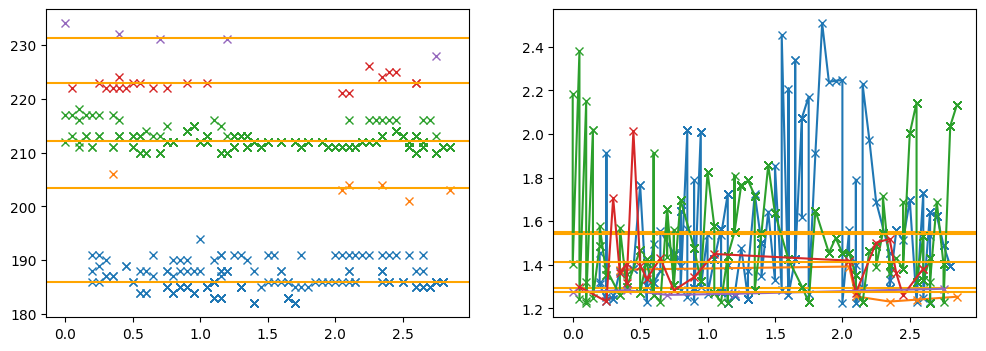

In [52]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

for tracker in stable_tracks:
    times, freqs, heights = np.array(tracker).T
    if len(times) < 5:
        continue
    times = spect.timestep*times
    freqmean = np.mean(freqs)
    heightmean = np.mean(np.exp(heights))

    ax[0].plot(times, freqs, 'x')#, color='tab:blue')
    ax[0].axhline(freqmean, color='orange')
    ax[1].plot(times, np.exp(heights),'x-')
    ax[1].axhline(heightmean, color='orange')

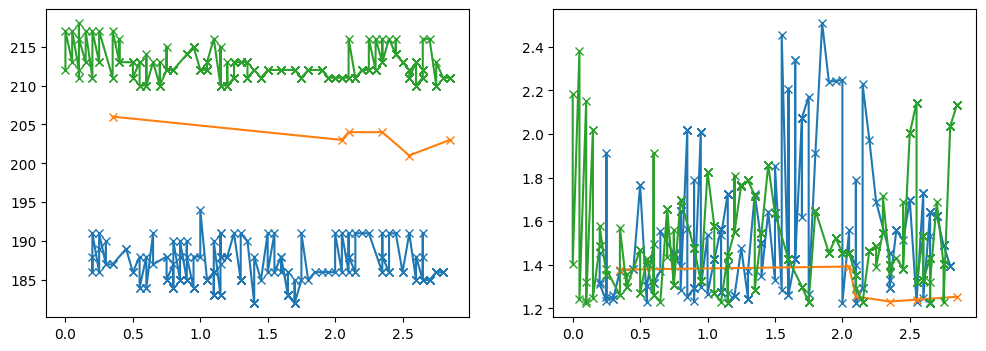

In [53]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

nlines = 3
for tracker in stable_tracks:
    if len(tracker)<5:
        continue
    times, freqs, heights = np.array(tracker).T
    times = spect.timestep*times
    ax[0].plot(times, freqs, 'x-')#, color='tab:blue')
    ax[1].plot(times, np.exp(heights),'x-')
    nlines -= 1
    if not nlines:
        break

In [55]:
U = np.array([spect.frequencies[int(i)] for i in np.array(stable_tracksfreqs)])
U/U[0]

array([1.        , 1.22405354, 1.45565318, 1.73107312, 2.05860447,
       2.66967971, 3.56359487, 4.62141079, 5.0396842 ])

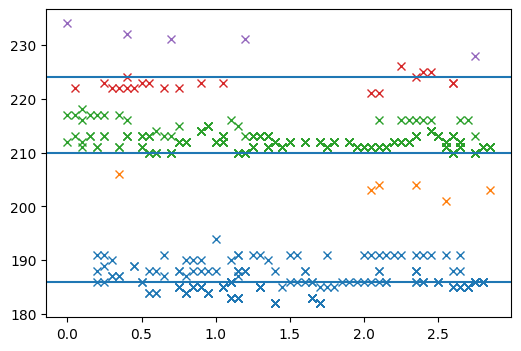

In [58]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

for tracker in stable_tracks:
    times, freqs, heights = np.array(tracker).T
    if len(times) < 5:
        continue
    times = spect.timestep*times
    freqmean = np.mean(freqs)
    heightmean = np.mean(np.exp(heights))

    ax.plot(times, freqs, 'x')#, color='tab:blue')
    #ax.axhline(freqmean, color='orange')
for n in range(1,4):
    ax.axhline(stable_tracksfreqs[1] + spect.Noctave*np.log(n)/np.log(2))